# physics724: Advanced Methods of Data Analysis

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE". Remember to delete the `raise NotImplementedError()` statements as you implement your solutions.

---

# Exercise 1: Maximum-likelihood fitting

In this exercise we will implement a maximum-likelihood fit using the common example of fitting a Gaussian curve to some normally-distributed data.

The main task will be to implement a gradient-descent algorithm.

If you do not want to work in Jupyter, (e.g. you are reading the HTML version of this problem sheet) then we ask that you implement three classes (in python or C++) with the following functionality:
1. A parameter class with a value and minimum/maximum allowed values. Write some functions that perform sanity checks when updating the value or setting the allowed range.
2. A Gaussian PDF class that stores two parameters and evaluates the log-likelihood over a dataset.
3. A minimiser class that uses a gradient-descent algorithm to fit a PDF to data.

You are then asked to fit the provided dataset using your PDF and minimiser.

You do not need to reproduce the plots in the final cell, although you may find it helpful to make them in order to test the performance of your minimiser.

You can of course use (or port) the skeleton code provided in the cells below.

## Problem 1 (of 1)

### Parameters

As a warm-up task to get you familiar with programming in Jupyter, here we have partially implemented a `parameter` class for you to use later in the problem. Some sanity checks are described in the *docstring* of the member functions `set_limits` and `set_value`.

Your first task is to implement the described behaviour.

There are some tests in the cell afterwards to check your solution.

In [5]:
class parameter:
    """
    This is a simple class that holds the value and allowed range of a parameter to be used in a PDF.
    
    Its member variables are:
        value: the current value
        min: the lower limit of the allowed range
        max: the upper limit of the allowed range
    """
    def __init__(self, start_value, min_value, max_value):
        """
        This function is called when you create an object of this class.
        It sets the values of the member variables to the arguments of the constructor.
        """
        self.set_limits(min_value, max_value)
        self.set_value(start_value)
    
    def set_limits(self, min_value, max_value):
        """
        Store the passed values to the variables self.min and self.max
        Check that the ranges make sense (max_value > min_value).
        Raise an exception if they do not.
        """
        if max_value < min_value:
            raise ValueError("Minimum value should be less than Maximum Value")
        self.min = min_value
        self.max = max_value
    
    def set_value(self, value):
        """
        Store the starting value to self.value while checking that it is within the limits.
        If outside the limits, set self.value to the closest one.
        """
        if value <= self.min:
            self.value = self.min
        elif value >= self.max:
            self.value = self.max
        else:
            self.value = value
    
    def __str__(self):
        """
        This function allows you to call print() on an object of this class.
        """
        return f"value: {self.value}, limits: [{self.min}, {self.max}]"
    
test_parameter= parameter(0,1,2)
print(test_parameter)    

value: 1, limits: [1, 2]


In [8]:
# This is a read-only cell, please do not edit it.
"""
This cell performs some sanity checks.
"""
# Test whether setting invalid values for the parameter ranges results in an
# exception.
threw_exception = False
try:
    test_parameter = parameter(0, 2, 1)
except Exception as e:
    print(e)
    threw_exception = True
assert(threw_exception)

# Test whether setting a value outside the allowed range results in the value
# being set to the nearest boundary.
test_parameter = parameter(3, 1, 2)
assert(test_parameter.value == test_parameter.max)
test_parameter = parameter(0, 1, 2)
assert(test_parameter.value == test_parameter.min)

Minimum value should be less than Maximum Value


### PDFs

Here we have a PDF base class and a partially-implemented Gaussian PDF class.

The base class defines some functions that all other classes inheriting from it should have:
- `__init__(...)`: the constructor/initialiser, which stores the list of parameters given to it
- `__call__(x)`: evaluate the PDF at point x (must be re-implemented by inheriting classes)
- `nLL(data)`: return the negative log-likelihood of the PDF evaluated over the dataset `data`

Don't worry too much about what `*args` and `**kwargs` mean. These just allow passing around additional arguments.

To extend this base class with some useful PDFs, you just need to implement the `__call__(x)` function.

A Gaussian PDF is defined as:
$$
PDF(x|\mu,\sigma) = \frac{1}{\sigma \sqrt{2 \pi}} \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

Your second task is to implement this function in the partially-implemented `gaussian_pdf` class below.

In [10]:
import numpy as np
import math

class pdf_base:
    """
    A base class for PDF objects. You don't need to modify this.
    """
    def __init__(self, *args):
        self.parameters=args
    def __call__(self, x, *args, **kwargs):
    
    def nLL(self, data, *args, **kwargs):
        return -sum([math.log(self.__call__(x, *args, **kwargs)) for x in data])

class gaussian_pdf(pdf_base):
    def __call__(self, x, mu = None, sigma = None):
        """
        Evaluate a normalised Gaussian PDF (normal distribution) at point x given parameters mu and sigma.
        
        To assist in quickly evaluating the PDF for different values of parameters (e.g. in likelihood scans or
        when calculating gradients), we have some extra arguments `mu` and `sigma`.
        You may notice that if they are not specified, they are set to the values of the stored parameters.
        """
        if mu == None: mu = self.parameters[0].value
        if sigma == None: sigma = self.parameters[1].value
        return (1/(np.sqrt(2*np.pi)*sigma)) * np.exp( (-1/2) * ( (x-mu)/sigma) **2)


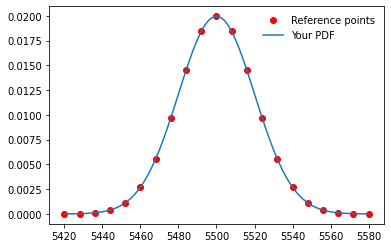

In [11]:
# This is a read-only cell, please do not edit it.
"""
This cell will produce a plot comparing your implementation of a Gaussian PDF to a reference from SciPy
"""
import numpy as np
from scipy import stats

# Initialise your PDF and a reference to check it against
mass = parameter(5500, 5000, 6000)
width = parameter(20, 1, 100)
reference_pdf = stats.norm(mass.value, width.value)
test_pdf = gaussian_pdf(mass, width)

# Points for the x-axis
plot_range = (mass.value-4*width.value, mass.value+4*width.value)
pdf_test_values_coarse = np.linspace(*plot_range, 21)
pdf_test_values_fine = np.linspace(*plot_range, 100)

# Overlay your PDF onto the reference points
from matplotlib import pyplot
pyplot.plot(pdf_test_values_coarse, reference_pdf.pdf(pdf_test_values_coarse), "ro", label="Reference points")
pyplot.plot(pdf_test_values_fine, [test_pdf(x) for x in pdf_test_values_fine], label="Your PDF")
pyplot.legend(loc='best', frameon=False)

# Test agreement
for x in pdf_test_values_coarse:
    assert(abs(test_pdf(x) - reference_pdf.pdf(x)) < 1e-6)


### Minimisation

#### Gradient descent

Gradient descent is a method of finding the local minimum of a differentiable function  by following the local gradient.

Say we have a multivariate function $f(\vec{x})$, where $\vec{x} = [x_1, x_2, ..., x_n].$

Its gradient is $$\nabla f(\vec{x}) = \left[\frac{\partial f}{\partial x_1}, \frac{\partial f}{\partial x_2}, ..., \frac{\partial f}{\partial x_n}\right].$$

Starting from some initial position $\vec{x}_i$, one can descend the gradient towards the local minimum by subtracting an amount proportional to the local gradient: $$\vec{x}_{i+1} = \vec{x}_i - \gamma_i \nabla f(\vec{x}_i),$$ where $\gamma_i$ is the "step size". This can be repeated until $\vec{x}$ converges to the local minimum.

Choosing an appropriate step size is crucial for an optimal balance between speed and precision, and many methods are available for doing this. Note that it does not need to be a fixed size and can be adjusted at each iteration.

Below we have a partially-implemented class called `minimiser`.
Your task is to implement a gradient-descent algorithm within the `minimise` function.

Please do not change the name of the class or remove the member variable `tested_points`, since these will be used in the cell below your solution.

In [91]:
class minimiser:
    def __init__(self, tolerance = 1e-2, max_step = 10):
        self.max_step = max_step
        self.tolerance = tolerance
        self.tested_points = []
    def __call__(self, pdf, data):
        """
        This function fits the passed PDF to the given dataset.
        The PDF should be of a class that inherits from the pdf_base class defined above.
        The dataset should be an iterable list of values which the PDF can evaluate.
        """
        for nstep in range(self.max_step):
            # Please keep the following two lines
            nLL = pdf.nLL(data)
            self.tested_points += [[nLL]+[p.value for p in pdf.parameters]] # This will be used to make plots
            """
            Your tasks:
            1. Update the PDF parameters using gradient descent
            2. Decide whether the fit has converged and return True if it has.
            """
            sigma = pdf.parameters[1].value
            mu = pdf.parameters[0].value
            dfds = -(-len(data)/(np.sqrt(2*np.pi)*sigma) + np.sum((np.array(data) - mu)**2 / sigma**3))
            dfdm = -(np.sum((data-mu)/sigma**2))
            gamma = 1.5
            sigma = sigma  - gamma*dfds
            mu = mu - gamma *dfdm
            if np.abs(pdf.parameters[1].value - sigma)< self.tolerance and np.abs(pdf.parameters[0].value - mu)< self.tolerance:
                print('Mu and Sigma converge to %f and %f after %f steps.' %(mu,sigma,nstep))
                return True
                    
            pdf.parameters[1].value = sigma
            pdf.parameters[0].value = mu
            

In [92]:
"""
This cell generates some data according to a Gaussian distribution and then fits your PDF using your minimiser.
We have provided the starting values that we will use to test your solution, but feel free to explore the
how your minimiser behaves when you adjust them.
"""
import numpy as np

# Initialise a PDF with some parameters
mass = parameter(5375, 5200, 5400)
width = parameter(180, 80, 200)
test_pdf = gaussian_pdf(mass, width)

# Generate some data to fit
target_mass = 5300
target_width = 100
test_data = np.random.normal(target_mass, target_width, 1000)
np.savetxt("test_data.csv", test_data, delimiter=",")

# Save the shape of the initial PDF for later
plot_range = (4800, 6000)
plot_points = np.linspace(*plot_range, 100)
initial_pdf_points = [test_pdf(x) for x in plot_points]

# Run the minimiser
m = minimiser(max_step = 1000)
m(test_pdf, test_data)

Mu and Sigma converge to 5301.020494 and 158.247466 after 125.000000 steps.


True

Text(0.5, 0, 'Mass [MeV]')

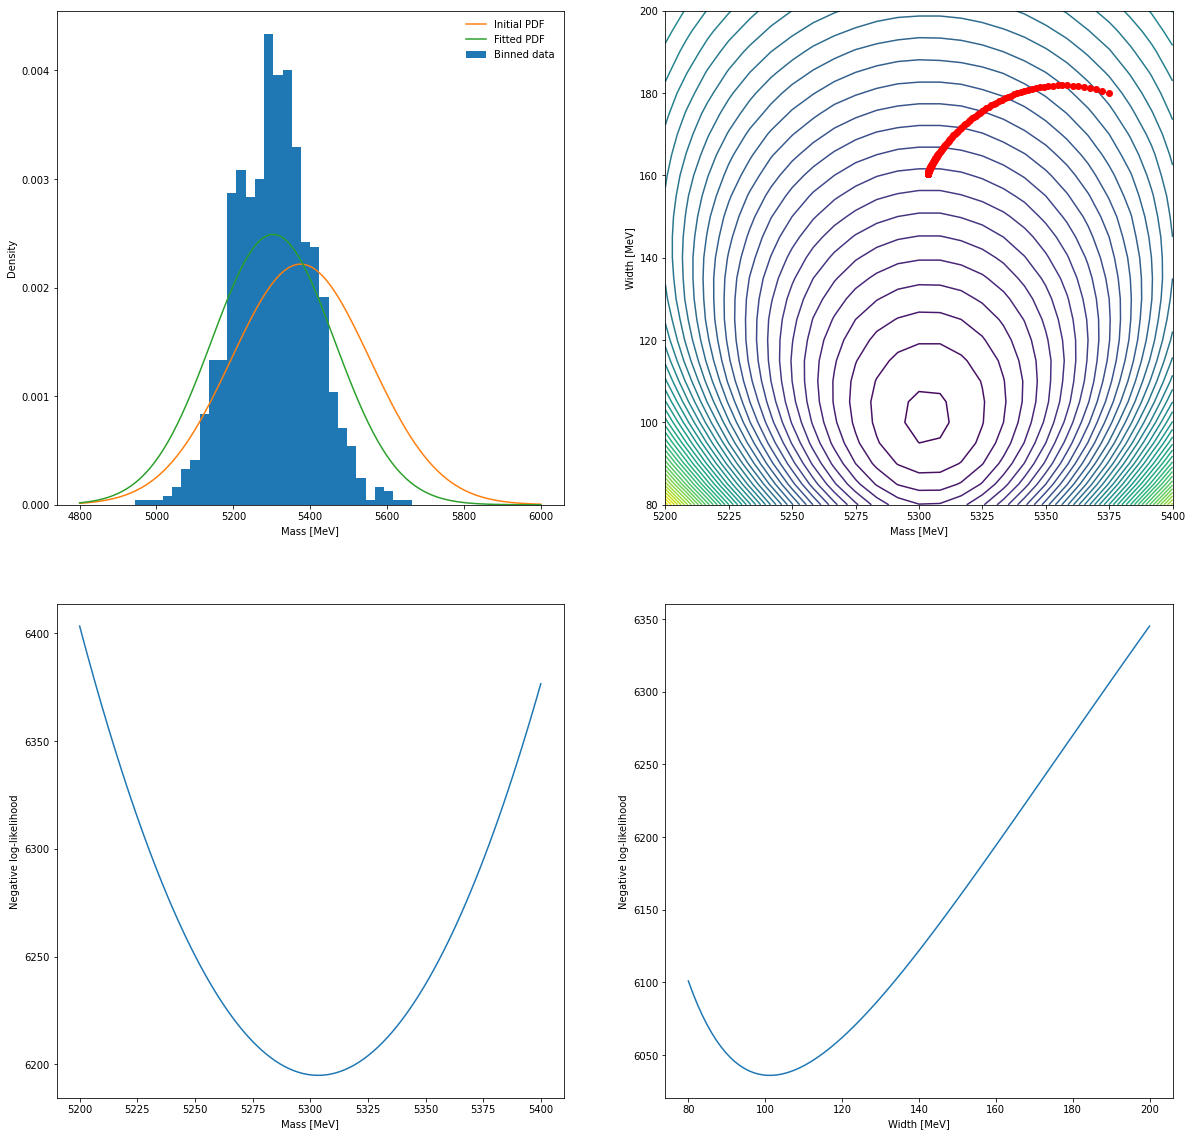

In [89]:
"""
This cell will create some plots using the fit from the cell above.
1. The initial and fitted PDFs overlaid onto the dataset.
2. A 2D contour plot of the likelihood with red markers showing the "descent" of the nLL towards the minimum
3. and 4. Likelihood profile scans of the fit parameters.
"""
# Create some plots
from matplotlib import pyplot
fig,((projection, cont), (lcurve_mass, lcurve_width)) = pyplot.subplots(2,2, figsize=(20,20))

# Overlay the initial and fitted PDFs on a binned distribution of the data
projection.hist(test_data, bins=50, range=plot_range, density=True, label="Binned data")
projection.plot(plot_points, initial_pdf_points, label="Initial PDF")
projection.plot(plot_points, [test_pdf(x) for x in plot_points], label="Fitted PDF")
projection.legend(loc='best', frameon=False)
projection.set_ylabel("Density")
projection.set_xlabel("Mass [MeV]")

# Retrieve the likelihood and parameter history
nLL_points = np.transpose(m.tested_points)

# Likelihood scan over mass
lcurve_mass_data = np.linspace(mass.min, mass.max, 100)
lcurve_mass.plot(lcurve_mass_data, [test_pdf.nLL(test_data, mu = m) for m in lcurve_mass_data])
lcurve_mass.set_ylabel("Negative log-likelihood")
lcurve_mass.set_xlabel("Mass [MeV]")

# Likelihood scan over width
lcurve_width_data = np.linspace(width.min, width.max, 100)
lcurve_width.plot(lcurve_width_data, [test_pdf.nLL(test_data, sigma = w) for w in lcurve_width_data])
lcurve_width.set_ylabel("Negative log-likelihood")
lcurve_width.set_xlabel("Width [MeV]")

# Likelihood contour plot
N = 25
cont_x = np.linspace(mass.min, mass.max, N)
cont_y = np.linspace(width.min, width.max, N)

Z = np.array([[0]*N]*N)
for i,x in enumerate(cont_x):
    for j,y in enumerate(cont_y):
        Z[j][i] = test_pdf.nLL(test_data, x, y)

cs = cont.contour(*np.meshgrid(cont_x,cont_y), Z, 50)
cont.plot(*nLL_points[1:], "ro")
cont.set_ylabel("Width [MeV]")
cont.set_xlabel("Mass [MeV]")